In [1]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
import ProgressMeter

In [2]:
data_seed, params_seed = 42, 120

(42, 120)

In [3]:
import ReactiveMP.messageout

In [4]:
include("../helpers/data.jl")

generate_data

In [5]:
# order = 1
Y = zeros(3); Y[1] = 1.0;
U = zeros(3); U[2] = 1.0;
H = zeros(3); H[3] = 1.0;

In [157]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max(n, model_flow::FlowModel, params, h_prior, w_prior, y_prev, u)
    
    dimension = length(h_prior[1])

    # initialize variables
    h       = randomvar(n)
    hy      = randomvar(n)
    hyu     = randomvar(n)
    Ys      = randomvar(n)
    Us      = randomvar(n)
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(NormalMeanPrecision(0.0, 1e12))}  
    w       = randomvar()
    y       = datavar(Float64, n)

    ar_nodes = Vector{FactorNode}(undef, n)
    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    y_lat_3 = randomvar(n)
    
#     Ys = [Y*y_prev[i] for i in 1:n]
#     Us = [U*u[i] for i in 1:n]

    # create meta for AR
    AR_meta = ARMeta(Univariate, 1, ARsafe())
    # create meta compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params)) # default: FlowMeta(model, Linearization())
    h_0 ~ NormalMeanPrecision(h_prior[1], h_prior[2])

    θ   ~ NormalMeanPrecision(0.0, 1e12)
    w   ~ GammaShapeRate(w_prior[1], w_prior[2])
    
    h_prev = h_0
    for t in 1:n
        # specify latent state
        ar_nodes[t], h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
        Ys[t] ~ MvNormalMeanPrecision(Y*y_prev[t], 1e12*diageye(3))
        Us[t] ~ MvNormalMeanPrecision(U*u[t], 1e12*diageye(3))
        hy[t] ~ H*h[t] + Ys[t]
        hyu[t] ~ hy[t] + Us[t]
        y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta}
        y_lat_2[t] ~ dot(y_lat_1[t], ones(dimension*3))
        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_2[t], w)
        h_prev = h[t]
    end

    return h, hy, hyu, θ, w, y_lat_1, y_lat_2, y, y_nodes
end

nonlinear_max (generic function with 1 method)

In [158]:
function nonlinear_max_inference(observations, observations_prev, controls, model_flow::FlowModel, params; 
                                 h_prior=(0.0, 0.1), w_prior=(0.1, 1.0), vmp_its=10)
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, hy, hyu, θ, w, y_lat_1, y_lat_2, y, y_nodes) = nonlinear_max(n, model_flow, params, h_prior, w_prior,
                                                                       observations_prev, controls,
                                                                       options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    hy_buffer = Vector{Marginal}(undef, n)
    hyu_buffer = Vector{Marginal}(undef, n)
    θ_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    w_buffer = nothing
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    hy_sub = subscribe!(getmarginals(h), (x) -> copyto!(hy_buffer, x))
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)
    θ_sub = subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))

    setmarginal!(w, GammaShapeRate(w_prior[1], w_prior[2]))
    setmarginal!(θ, NormalMeanPrecision(0.0, 1e12))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # unsubscribe
    unsubscribe!(fe_sub)
    unsubscribe!(h_sub)
    unsubscribe!(w_sub)
    unsubscribe!(θ_sub)
    
    # return the marginal values
    return fe_buffer, h_buffer, hy_buffer, hyu_buffer, w_buffer, y_out_buffer, θ_buffer
    
end

nonlinear_max_inference (generic function with 1 method)

In [168]:
# specify flow model
dimension = 3
model_flow = FlowModel(dimension,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [169]:
Random.seed!(data_seed)

n_samples = 100
u = 3 .* sin.(collect(1:n_samples+10))
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>1, :order_u=>1, :order_e=>1),
                                                     Dict(:er_var=>1e-2, :u=>u));

In [170]:
observations_prev = y_obs[1:end-1]
observations      = y_obs[2:end];
controls          = u[1:end];

In [171]:
train_size = 80
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

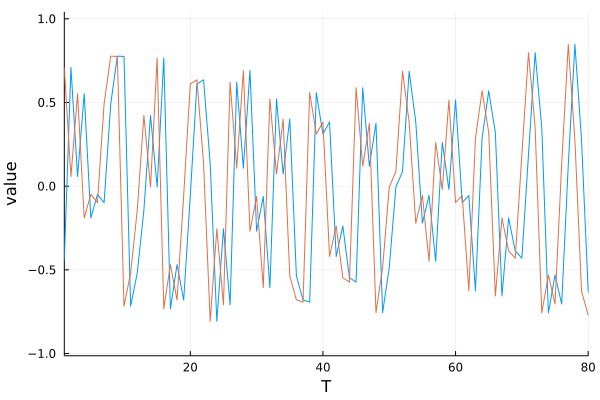

In [172]:
from, to = 1, 80
plot(y_obs, xlims=(1, train_size))
plot!(Y_train, xlims=(from, to), xlabel="T", ylabel="value", legend=false)

In [173]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
model_params = randn(flow_param_len)

18-element Vector{Float64}:
 -0.9194589934298287
  1.0117762040383562
 -0.008656271104353946
 -1.7061637862602859
 -0.38240881051735015
  1.142903405886922
  1.5994173837327952
 -0.6606269914068376
  1.7280026513115074
 -0.13897835603040912
 -0.6737809225295219
  0.04878749639808164
  1.67258141660508
 -0.3197351351892221
 -1.2564553841314527
  0.9521825170300846
 -1.1950939635125657
 -0.8705419973267794

In [174]:
fe_, h_, hy_, hyu_, w_, y_out_, θ_ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, model_params, w_prior=(1e2, 1.0), vmp_its=5);


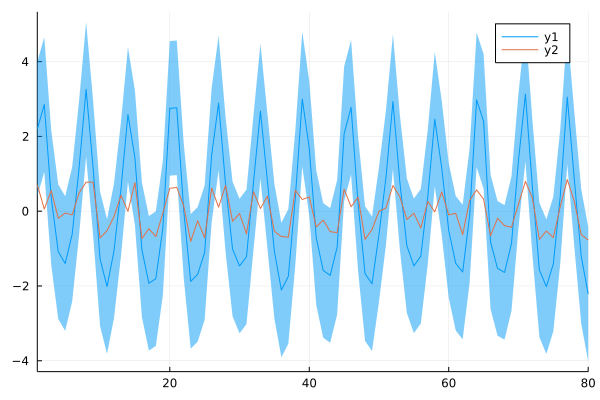

In [175]:
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(1, 80))

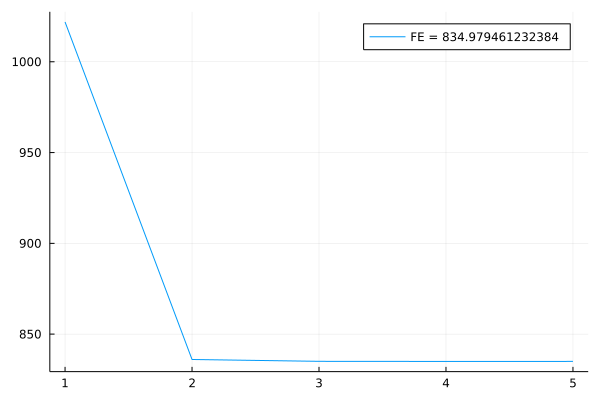

In [176]:
gr()
plot(fe_, label="FE = $(fe_[end])")

In [198]:
# Optimization function
function FE(params, p=nothing)
    fe, h, hy, hyu, w, y_out, θ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, params, 
                                                          h_prior=(0.0, 0.1), w_prior=(1e-4, 1e-4), 
                                                          vmp_its=5)
    return fe[end]
end;

In [199]:
FE(model_params)

316.4060771478253

In [26]:
# unpack if you don't want to run Optim
@unpack inf_params = JLD.load("../dump/flow_dataseed_$(data_seed)_paramsseed_$(params_seed).jld")

Dict{String, Any} with 1 entry:
  "inf_params" => [-1.94966, 1.56914, -0.146374, -0.203105, 2.60121, 6.77963, -…

In [74]:
import ReactiveMP.fastcholesky
using PositiveFactorizations

function ReactiveMP.fastcholesky(mat::AbstractMatrix)
    return cholesky(PositiveFactorizations.Positive, Hermitian(mat))
end

In [200]:
using Optim
res = optimize(FE, model_params, LBFGS(), Optim.Options(g_tol = 1e-12, iterations = 1000, store_trace = true, show_trace = true, show_every=10), autodiff=:forward)


Iter     Function value   Gradient norm 
     0     3.164049e+02     1.720507e+01
 * time: 0.00010395050048828125
    10     1.941325e+02     3.290763e+01
 * time: 5.865906000137329
    20     1.173753e+02     5.600007e+01
 * time: 10.397264003753662
    30     9.937121e+01     2.274559e+01
 * time: 15.08732795715332
    40     9.054994e+01     2.951821e+01
 * time: 19.038182973861694
    50     8.276124e+01     5.338945e+01
 * time: 24.259798049926758
    60     7.691588e+01     6.407843e+00
 * time: 28.94538402557373
    70     7.258442e+01     2.131431e+01
 * time: 42.75488305091858


 * Status: success

 * Candidate solution
    Final objective value:     7.216646e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 5.20e-18 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.08e-19 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.16e+01 ≰ 1.0e-12

 * Work counters
    Seconds run:   107  (vs limit Inf)
    Iterations:    75
    f(x) calls:    597
    ∇f(x) calls:   597


In [201]:
inf_params = Optim.minimizer(res)

18-element Vector{Float64}:
 -1.701865519856279
  0.8485569682957866
  0.2450381104446891
 -1.629375818933013
  0.34917842408029753
  0.217308542270404
  1.2372563092431985
  1.641942209236377
  2.26142093466026
  1.1035528979234204
 -0.5752919539843923
 -0.3873091932195255
  5.729526774545574
 -0.44024901747762585
  0.09437133165384491
  4.1771094116550245
 -0.9500236070061253
 -0.011341661831409956

In [121]:
using JLD
JLD.save("../dump/flow_dataseed_$(data_seed)_paramsseed_$(params_seed).jld", "inf_params", inf_params)

In [202]:
FE(inf_params)

73.05817065340852

In [203]:
fe_, h_, hy_, hyu_, w_, y_out_, θ_ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, inf_params, w_prior=(1e-4, 1e-4),  vmp_its=10);


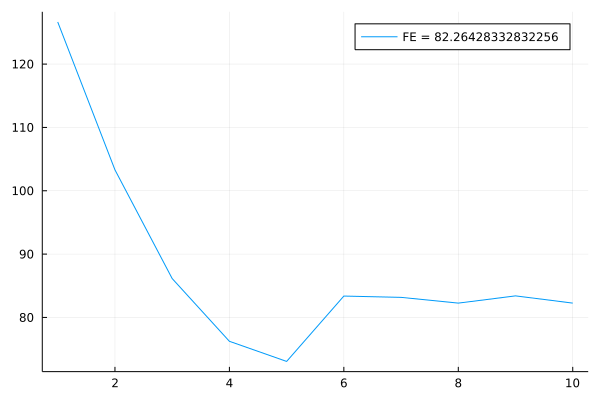

In [204]:
plot(fe_[1:end], label="FE = $(fe_[end])")

In [205]:
from, to = 1, 80

(1, 80)

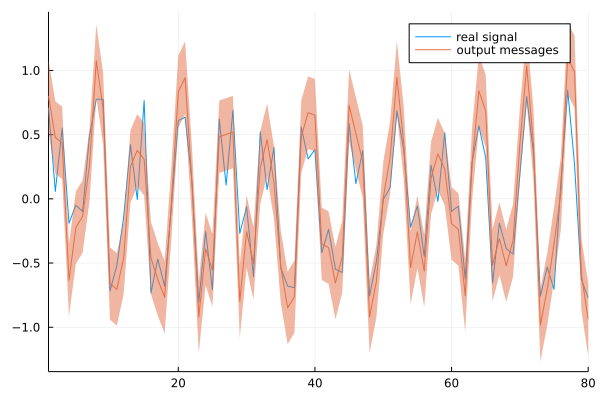

In [206]:
my, vy = mean.(y_out_), cov.(y_out_)
plot(Y_train, xlims=(from, to), label="real signal")
plot!(my, ribbon=sqrt.(vy), label="output messages")

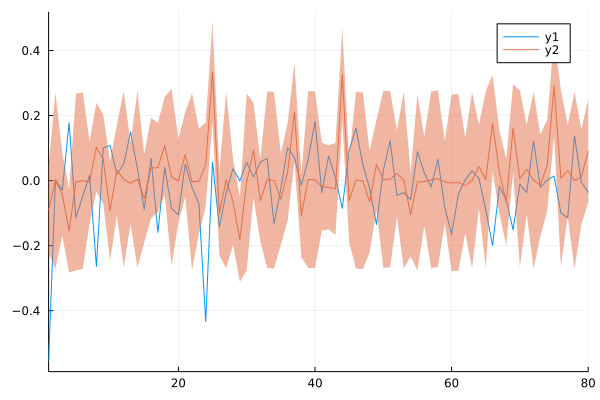

In [207]:
mh, vh = mean.(h_), cov.(h_)
plot(h_gen)
plot!(first.(mh), ribbon=sqrt.(first.(vh)), xlims=(from, to))

### KF-like prediction

In [208]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction_model(model_flow::FlowModel, params, w, h_prior, y_prev, u)
    
    dimension = length(h_prior[1])

    # initialize variables
    y_pred   = datavar(Float64)
    
#     Ys = Y*y_prev
#     Us = U*u
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end-2]
    params_w = params[end-1:end]

    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(NormalMeanPrecision(h_prior[1], h_prior[2]))}

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ NormalMeanPrecision(h_prior[1], h_prior[2])
    
    h ~ NormalMeanPrecision(h_0, w) where {q = q(h_0, h)q(w)}
    
    Ys ~ MvNormalMeanPrecision(Y*y_prev, 1e12*diageye(3))
    Us ~ MvNormalMeanPrecision(U*u, 1e12*diageye(3))
    hy ~ H*h + Ys
    hyu ~ hy + Us
    
    y_lat_1 ~ Flow(hyu) where { meta = Flow_meta, q = FullFactorisation() }
    
    y_lat_2 ~ dot(y_lat_1, ones(dimension*3))

    y_node, y ~ NormalMeanPrecision(y_lat_2, w) where { q = q(y, y_lat_2)q(w)}
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred
end

nonlinear_max_prediction_model (generic function with 1 method)

In [209]:
function nonlinear_max_prediction(observation_prev::T, control::T, model_flow::FlowModel, params; 
                                  h_prior=(ones(2), diageye(2)), w=1.0, vmp_its = 50) where T<:Float64

    # define model
    model, (h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred) = nonlinear_max_prediction_model(model_flow, params, w, h_prior,
                                                                                          observation_prev, control,
                                                                                          options = (limit_stack_depth = 500, ))
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

nonlinear_max_prediction (generic function with 1 method)

In [259]:
predictions = []
h_prev = (mean(h_[end]), precision(h_[end]))
ŵ = mean(w_)
for i in 1:length(X_test)
    fe, h, h_0, y_pred = nonlinear_max_prediction(X_test[i], U_test[i], model_flow, inf_params, h_prior=h_prev, w=ŵ, vmp_its=10)
    push!(predictions, y_pred)
    _, h_inf, _, _, _ = nonlinear_max_inference([Y_test[i]], [X_test[i]], [U_test[i]], model_flow, inf_params, h_prior=h_prev, w_prior=(ŵ, 1.0), vmp_its=10);
    h_prev = (mean.(h_inf)[1], precision.(h_inf)[1])
end

In [260]:
mx, vx = mean.(predictions), cov.(predictions)

([-0.9799267204842909, -0.2712934517143923, 2.5449532707554865, 1.8285121229302077, -0.2327034591762849, -3.357205926495826, -2.402234890733773, -0.018778698132450675, 2.521104364502526, 2.28861730500984, 0.5160919959539088, -1.435500116037583, -5.196371880497533, 0.020169809222377804, 0.38933660246517815, 2.541526475248246, 0.42569329401439276, -0.7482401178448076, -5.070799003406538, -0.4890506667267737], [0.3489195151900954, 0.4209815840073657, 1.009170451169193, 0.3013523338375697, 0.25473091144976723, 2.6867944654468845, 1.8552760867457538, 0.5747083348291776, 0.9427975961062245, 0.5154723181810829, 0.23101208343909826, 0.3018622258076436, 2.4352393343909746, 0.3339023450384015, 0.11555507001307226, 1.0224395971648903, 0.17091137410072707, 0.11785637456490314, 2.0725165078095418, 0.14174455149267162])

In [261]:
test_from, test_to = 1, 20

(1, 20)

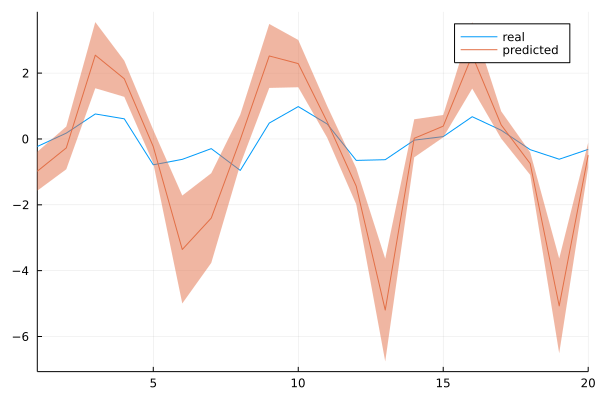

In [262]:
plot(Y_test, label="real")
plot!(mx, ribbon=sqrt.(vx), xlims=(test_from, test_to), label="predicted")